# Test of particle pusher (Boris method) in electromagnetic field
The Boris method for particle positions and velocities reads as follows:

\begin{align}
q^\prime=\Delta t\frac{q}{2m} \\
\textbf{h} = q^\prime\textbf{B}(\textbf{x}^n) \\
\textbf{s}=2\textbf{h}/(1+h^2) \\
\textbf{u}=\textbf{v}^{n-1/2}+q^\prime\textbf{E}(\textbf{x}^n) \\
\textbf{u}^\prime=\textbf{u}+(\textbf{u}+(\textbf{u}\times\textbf{h}))\times\textbf{s} \\
\textbf{v}^{n+1/2}=\textbf{u}^\prime+q^\prime\textbf{E}(\textbf{x}^n) \\ 
\textbf{x}^{n+1}=\textbf{x}^n+\Delta t\textbf{v}^{n+1/2} 
\end{align}

As an example the method is applied to some particles in a constant magnetic field $\textbf{B}_0=B_{0z}\textbf{e}_z$ and electric field $\textbf{E}_0=E_{0x}\textbf{e}_x+E_{0y}\textbf{e}_y$.

This leads to an $\textbf{E}\times\textbf{B}$-drift.

Text(0.5,0.92,'Verification of particle mover')

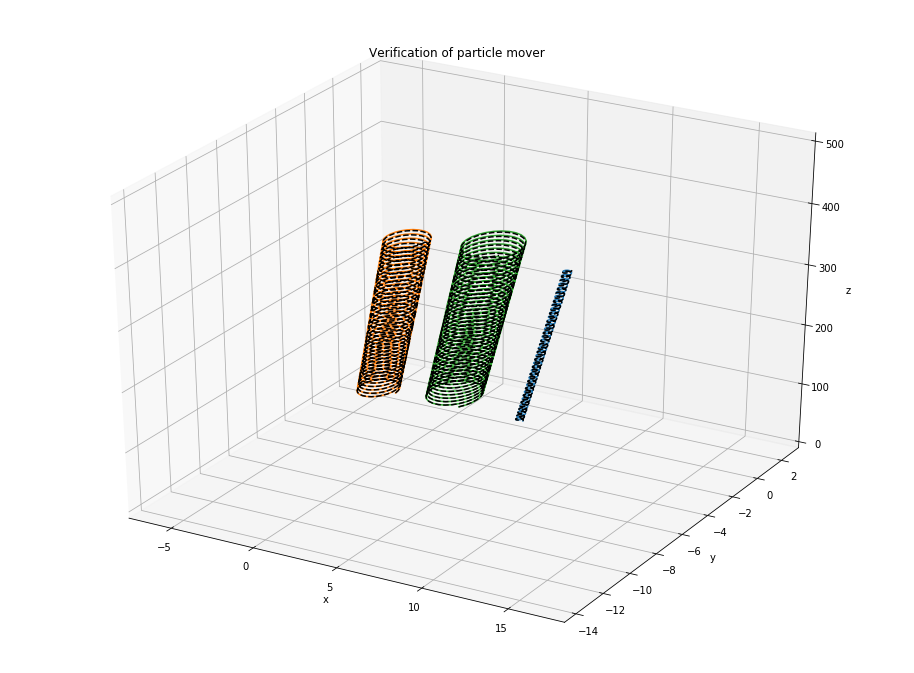

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from copy import deepcopy



# ... parameters
q = -1                          # ... charge of particle
m = 1                           # ... mass of particle
T = 40*2*np.pi                  # ... simulation time
Nt = 1000                       # ... number of time steps
dt = T/Nt                       # ... time step
B0z = 1.0                       # ... field at x = 0 for magnetic mirror
Omega = q*B0z/m                 # ... cyclotron frequency
B0 = np.array([0,0,B0z])        # ... constant background magnetic field
E0 = np.array([0.05,0.05,0])    # ... constant background electric field
Np = 3                          # ... number of particles
Lx = 600
Lv = 5.0
# ...

tn = np.linspace(0,T,Nt+1)
particles = np.zeros((Nt+1,3,6))


# ... initialize velocities
particles[0,0,3:6] = np.array([0.,0.14,2.]) 
particles[0,1,3:6] = np.array([0.,1.,2.]) 
particles[0,2,3:6] = np.array([1.,1.,2.]) 

rl1 = np.abs(m*particles[0,0,4]/(q*np.linalg.norm(B0)))
rl2 = np.abs(m*particles[0,1,4]/(q*np.linalg.norm(B0)))

particles[0,0,0] = 4.
particles[0,1,0] = -4.
particles[0,2,0] = 0.


v0 = deepcopy(particles[0,:,3:6])
x0 = deepcopy(particles[0,:,0:3])

def analytical(x0,v0,t):
    
    x = x0[0] + 1/Omega*(E0[0]/B0z + v0[1])*(1 - np.cos(Omega*t)) + 1/Omega*(v0[0] - E0[1]/B0z)*np.sin(Omega*t) + E0[1]/B0z*t
    y = x0[1] + 1/Omega*(E0[1]/B0z - v0[0])*(1 - np.cos(Omega*t)) + 1/Omega*(v0[1] + E0[0]/B0z)*np.sin(Omega*t) - E0[0]/B0z*t    
    z = (x0[2] + v0[2]*t)%Lx
    
    return np.array([x,y,z])
    

Bp = np.zeros((3,3))
Ep = np.zeros((3,3))


def pushBoris(particles,dt,B,E):
    
    qprime = dt*q/(2*m)
    h = qprime*B
    s = 2*h/(1 + np.linalg.norm(h,axis = 1)**2)[:,None]
    u = particles[:,3:6] + qprime*E
    uprime = u + np.cross(u + np.cross(u,h),s)
    vnew = (uprime + qprime*E + Lv/2)%Lv - Lv/2
    xnew = (particles[:,0:3] + dt*vnew)
    xnew[:,2] = xnew[:,2]%L 
       
    return xnew,vnew


'''
def pushBoris(particles,dt,B,E):
    
    vhalf = particles[:,3:6] + dt/2*q/m*(E + np.cross(particles[:,3:6],B))
    xnew = (particles[:,0:3] + dt*vhalf)
    xnew[:,2] = xnew[:,2]%L 
    vnew = vhalf + dt/2*q/m*(E + np.cross(vhalf,B))
       
    return xnew,vnew
'''

particles[0,:,3:6] = pushBoris(particles[0],-dt/2,B0 + Bp,E0 + Ep)[1]

# ... time integration
for n in range(0,Nt):
    particles[n+1,:,0:3],particles[n+1,:,3:6] = pushBoris(particles[n],dt,B0 + Bp,E0 + Ep)
# ...


test0 = analytical(x0[0],v0[0],tn)
test1 = analytical(x0[1],v0[1],tn)
test2 = analytical(x0[2],v0[2],tn)


f1 = plt.figure()
f1.set_figheight(12)
f1.set_figwidth(16)
ax = f1.add_subplot(111,projection = '3d')
ax.plot(particles[:,0,0],particles[:,0,1],particles[:,0,2])
ax.plot(particles[:,1,0],particles[:,1,1],particles[:,1,2])
ax.plot(particles[:,2,0],particles[:,2,1],particles[:,2,2])
ax.plot(test0[0,:],test0[1,:],test0[2,:],'k--')
ax.plot(test1[0,:],test1[1,:],test1[2,:],'k--')
ax.plot(test2[0,:],test2[1,:],test2[2,:],'k--')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title('Verification of particle mover')

In [13]:
(particles[1,0,3] - particles[0,0,3])/dt

-0.18854165764683686

In [15]:
(particles[1,0,4] + particles[0,0,4])/2

0.138541657646837